In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import pdr
from astropy.visualization import ZScaleInterval
from gPhoton.lightcurve.photometry_utils import (mask_for_extended_sources,
                                                 image_segmentation,
                                                 check_point_in_extended)
from gPhoton.coadd import zero_flag_and_edge, flag_and_edge_mask
import scipy.sparse
import pandas as pd
import numpy as  np
from gPhoton.lightcurve._steps import get_point_and_extended_sources
from ast import literal_eval
from photutils.segmentation import detect_sources
from photutils.detection import DAOStarFinder
import imageio

from tqdm import tqdm

In [3]:
import warnings
warnings.simplefilter("ignore")

In [84]:
mcat = pdr.read('GI1_061002_NGC0300_0006-xd-mcat.fits.gz')
print(f"The MCAT for this eclipse contains {len(mcat['GALEX_MERGED_SOURCE_LIST'])} sources.")

The MCAT for this eclipse contains 10887 sources.


In [4]:
image_data = pdr.read('/Users/cm/github/gPhoton2/regr_test_data/e08556/e08556-nd-ffull-b00-image-r.fits')
expt = pd.read_csv('/Users/cm/github/gPhoton2/regr_test_data/e08556/e08556-nd-f0120-b00-movie-exptime.csv',index_col=None)
exptime = expt['expt'].sum()

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(ZScaleInterval()(image_data['CNT']/exptime),origin='lower',cmap='Greys')
plt.xticks([]);plt.yticks([]);
plt.savefig('/Users/cm/Downloads/000.png')

out = detect_sources(image_data['CNT']/exptime, 0.01, 2)
plt.figure(figsize=(20,20))
#plt.imshow(ZScaleInterval()(out),origin='lower',alpha=0.5,cmap='Greys')
plt.imshow(out,origin='lower',alpha=0.5,cmap='Greys')
plt.xticks([]);plt.yticks([]);
plt.savefig('/Users/cm/Downloads/001.png')

n_frames = 2
# write the animated gif
with imageio.get_writer(f'/Users/cm/Downloads/out.gif', mode='I', fps=2, loop=0) as writer:
    for i in np.arange(n_frames):
        image = imageio.imread(f'/Users/cm/Downloads/{str(i).zfill(3)}.png')
        writer.append_data(image)

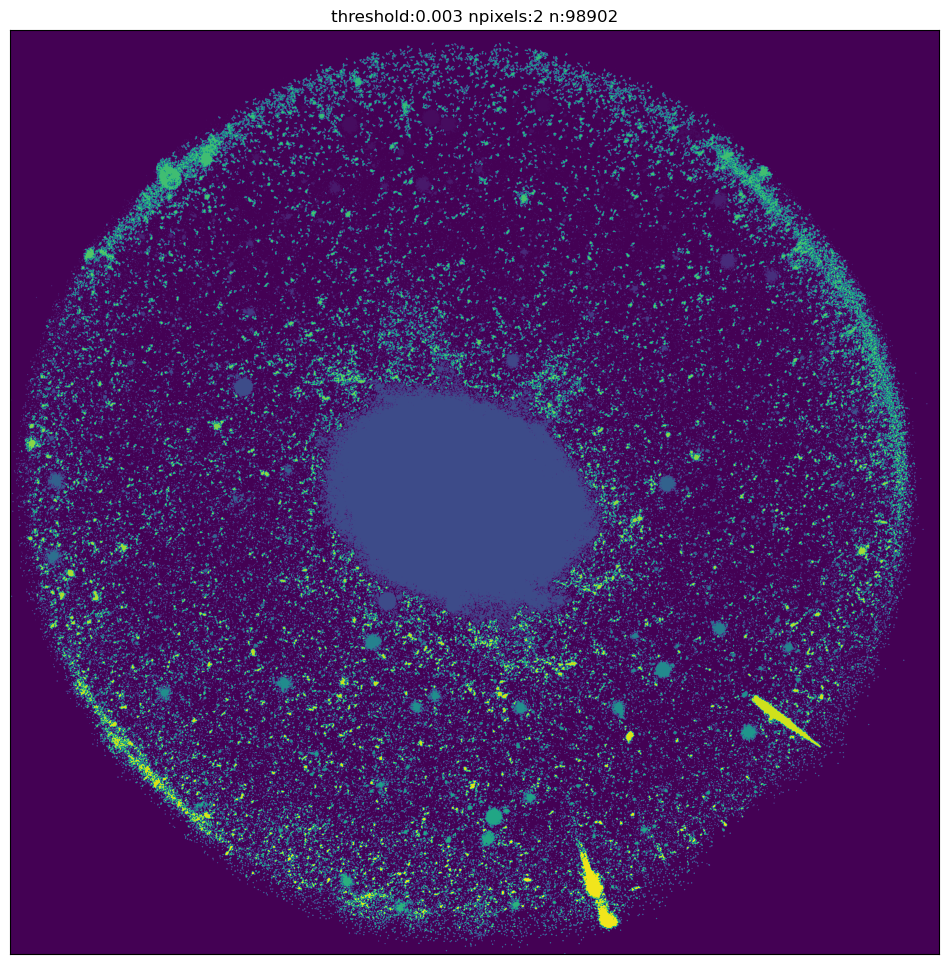

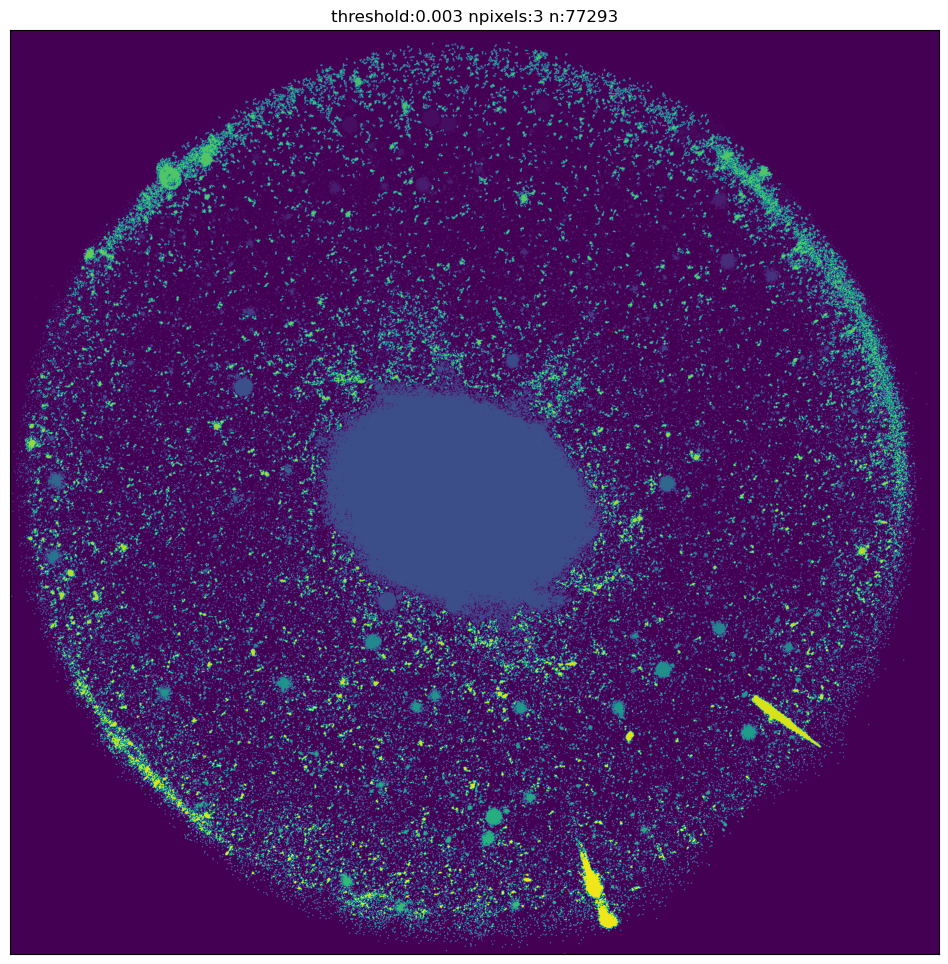

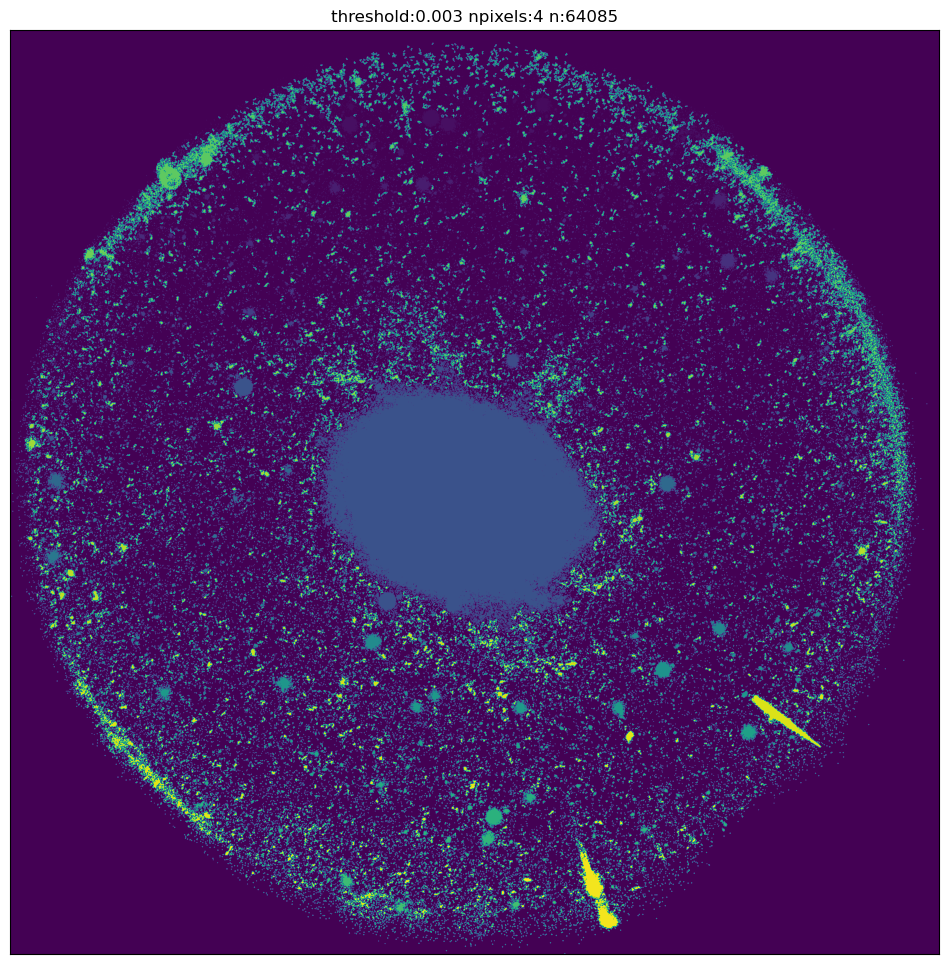

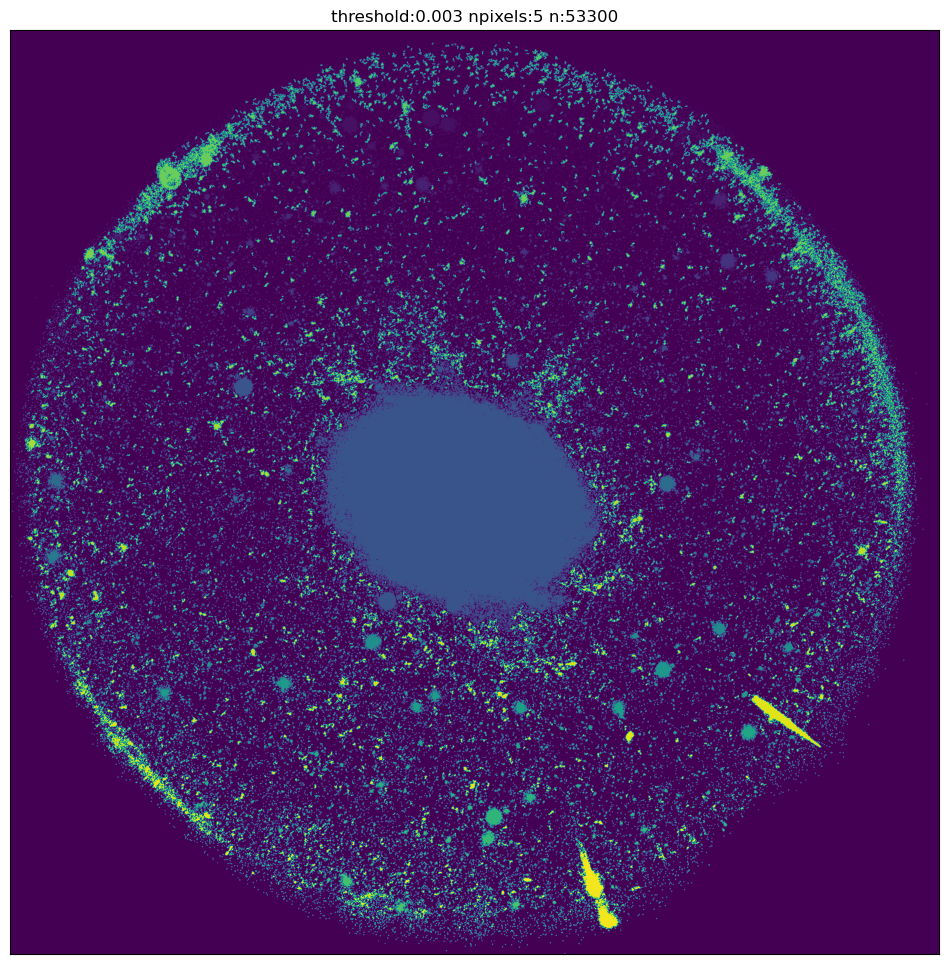

In [74]:
from photutils.segmentation import (detect_sources, make_2dgaussian_kernel,
                                    SourceCatalog, deblend_sources)
from scipy.ndimage import convolve

kernel = make_2dgaussian_kernel(fwhm=3, size=(3, 3))
convolved_data = convolve(image_data['CNT']/exptime, kernel)

n = []
th = [0.003]#np.arange(0.003,0.006,0.001)
for threshold in th:
    for npixels in [2,3,4,5]:
        segment_map = detect_sources(
            convolved_data, threshold, npixels=npixels, #mask=f_e_mask
        )
        segmap = deblend_sources(convolved_data,
                                                segment_map,
                                                npixels=npixels,
                                                nlevels=20,
                                                contrast=0.004,
                                                mode='linear',
                                                progress_bar=False)
        
        seg_sources = SourceCatalog(image_data['CNT']/exptime, segmap, convolved_data=convolved_data)#.to_table(columns=columns).to_pandas()
        
        n+=[len(seg_sources)]#.to_table()
        plt.figure(figsize=(12,12))
        plt.imshow(segmap)
        plt.xticks([]);plt.yticks([]);
        plt.title(f'threshold:{threshold} npixels:{npixels} n:{len(seg_sources)}')
        plt.show();

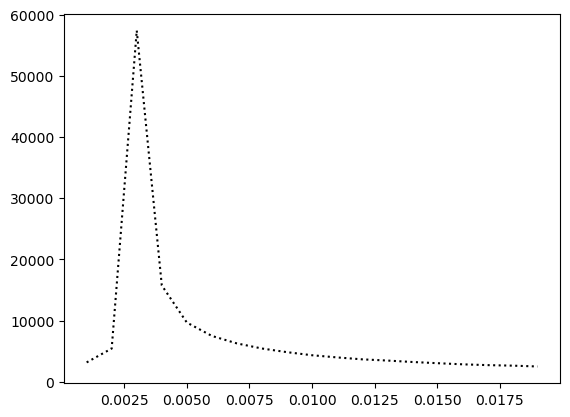

In [68]:
plt.plot(th,n,'k:')
plt.show()

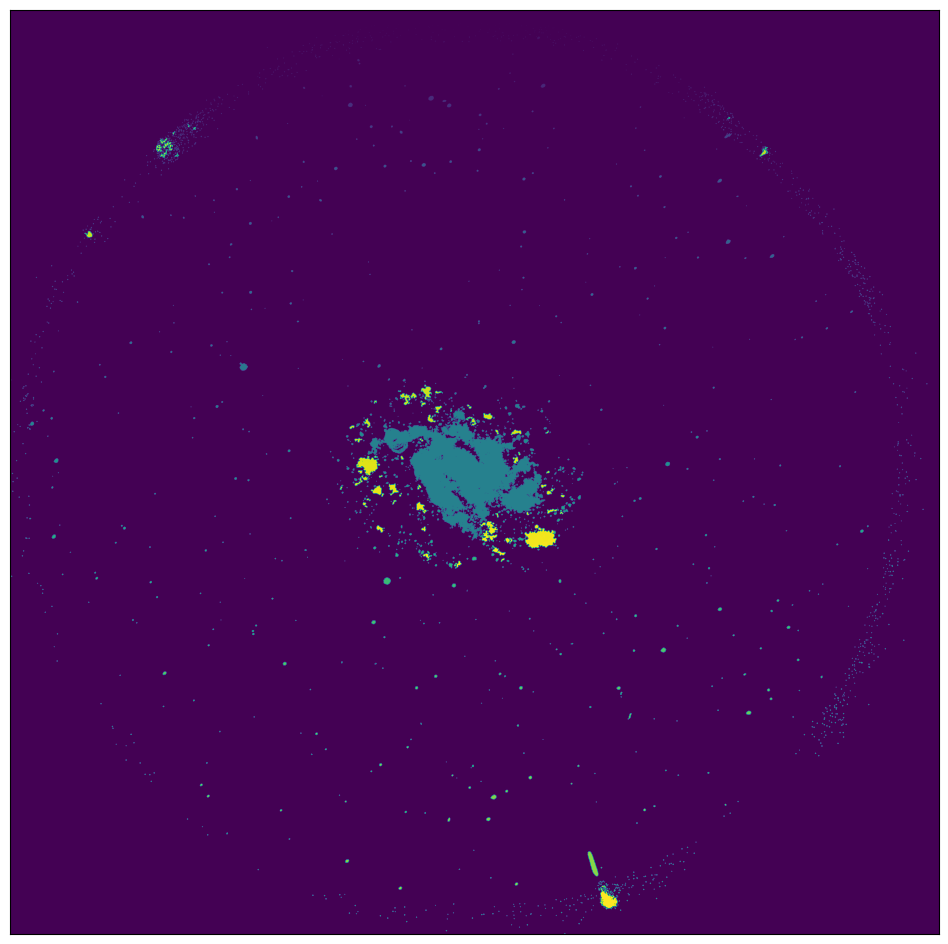

In [69]:
plt.figure(figsize=(12,12))
plt.imshow(segmap)
plt.xticks([]);plt.yticks([]);
plt.show();

In [56]:
columns = ['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux',
           'elongation', 'eccentricity', 'equivalent_radius', 'orientation',
           'max_value', 'maxval_xindex', 'maxval_yindex', 'min_value',
           'minval_xindex', 'minval_yindex', 'bbox_xmin', 'bbox_xmax',
           'bbox_ymin', 'bbox_ymax']

# runtime without `to_table()` is ~2ms
#%time seg_sources = SourceCatalog(image_data['CNT'], segmap, convolved_data=convolved_data)#.to_table(columns=columns).to_pandas()
# runtime with `to_table()` is ~13.0s
%time seg_sources = SourceCatalog(image_data['CNT'], segmap, convolved_data=convolved_data)#.to_table(columns=columns).to_pandas()

len(seg_sources)#.to_table()

CPU times: user 109 ms, sys: 24 ms, total: 133 ms
Wall time: 131 ms


57459

In [41]:
plt.figure(figsize=(20,20))
plt.imshow(ZScaleInterval()(image_data['CNT']/exptime),origin='lower',cmap='Greys')
plt.xticks([]);plt.yticks([]);
plt.savefig('/Users/cm/Downloads/000.png')

out = detect_sources(image_data['CNT']/exptime, 0.01, 2)
plt.figure(figsize=(20,20))
#plt.imshow(ZScaleInterval()(out),origin='lower',alpha=0.5,cmap='Greys')
plt.imshow(segmap,origin='lower',alpha=0.5,cmap='Greys')
plt.xticks([]);plt.yticks([]);
plt.savefig('/Users/cm/Downloads/001.png')

n_frames = 2
# write the animated gif
with imageio.get_writer(f'/Users/cm/Downloads/out.gif', mode='I', fps=2, loop=0) as writer:
    for i in np.arange(n_frames):
        image = imageio.imread(f'/Users/cm/Downloads/{str(i).zfill(3)}.png')
        writer.append_data(image)
plt.close('all')

In [44]:
? SourceCatalog

Init signature:
 SourceCatalog(
    data,
    segment_img,
    *,
    convolved_data=None,
    error=None,
    mask=None,
    background=None,
    wcs=None,
    localbkg_width=0,
    apermask_method='correct',
    kron_params=(2.5, 1.4, 0.0),
    detection_cat=None,
    progress_bar=False,
)
Docstring:     
Class to create a catalog of photometry and morphological properties
for sources defined by a segmentation image.

Parameters
----------
data : 2D `~numpy.ndarray` or `~astropy.units.Quantity`, optional
    The 2D array from which to calculate the source photometry and
    properties. If ``convolved_data`` is input, then a convolved
    version of ``data`` will be used instead of ``data`` to
    calculate the source centroid and morphological properties.
    Source photometry is always measured from ``data``. For
    accurate source properties and photometry, ``data`` should be
    background-subtracted. Non-finite ``data`` values (NaN and inf)
    are automatically masked.

segment

In [73]:
? deblend_sources

Signature:
 deblend_sources(
    data,
    segment_img,
    npixels,
    *,
    labels=None,
    nlevels=32,
    contrast=0.001,
    mode='exponential',
    connectivity=8,
    relabel=True,
    nproc=1,
    progress_bar=True,
)
Docstring:
Deblend overlapping sources labeled in a segmentation image.

Sources are deblended using a combination of multi-thresholding and
`watershed segmentation
<https://en.wikipedia.org/wiki/Watershed_(image_processing)>`_. In
order to deblend sources, there must be a saddle between them.

Parameters
----------
data : 2D `~numpy.ndarray`
    The 2D array of the image. If filtering is desired, please input
    a convolved image here. This array should be the same array used
    in `~photutils.segmentation.detect_sources`.

segment_img : `~photutils.segmentation.SegmentationImage`
    The segmentation image to deblend.

npixels : int
    The minimum number of connected pixels, each greater than
    ``threshold``, that an object must have to be deblended.
   